# Text Autocompletion Project — From LSTM to Transformers

This notebook-style Python script implements the complete pipeline required by the
project brief. It is structured as a sequence of Markdown explanations followed by
executable cells. The scope and goals mirror the assignment:

- Prepare and normalize a corpus of short posts from a line-delimited text file.
- Build and train a compact next-token LSTM language model suitable for constrained
  devices.
- Measure quality using ROUGE-1 and ROUGE-2 on held-out text completions (predicting
  the last quarter of each text from the first three quarters).
- Benchmark against a pretrained transformer baseline (DistilGPT2) using a simple
  generation pipeline.
- Compare results and provide a concise conclusion.

The machine learning formulation is next-token prediction: given tokens
$(w_1, \dots, w_n)$, the model estimates $P(w_{n+1} \mid w_{\le n})$ and we
iteratively generate until an end token or a maximum length is reached.

Datasets are split deterministically into train/validation/test, tokenized at the
word level with special tokens `<pad>`, `<unk>`, `<bos>`, `<eos>`, and converted into
shifted input/target tensors for supervised learning.

Evaluation follows the assignment’s rule of using the first 75% tokens of each text as
the prefix and comparing generated completions to the remaining 25% via ROUGE.

In [1]:
from __future__ import annotations

import logging
from pathlib import Path

import matplotlib.pyplot as plt

from src.config_utils import LSTMConfig, load_config_model
from src.data_utils import load_processed_texts, preprocess_dataset, split_and_persist_texts
from src.eval_lstm import evaluate_on_texts
from src.eval_transformer_pipeline import evaluate_gpt2_on_texts
from src.lstm_model import LSTMLanguageModel
from src.lstm_train import create_optimizer_scheduler, save_checkpoint, train_epoch, valid_epoch
from src.next_token_dataset import create_next_token_dataloaders
from src.project_utils import initialize_runtime, print_environment
from src.summary import print_comparison, print_scores, show_examples
from src.tokenizer_vocab import WordVocab, build_supervised_tensors

logging.basicConfig(level=logging.INFO)

## Configuration

We load a typed configuration object that centralizes paths, data limits, model
hyperparameters, training settings, and generation defaults. This ensures the entire
experiment is reproducible and easy to tweak without touching the code.

In [2]:
CFG = load_config_model()

## Runtime Initialization

We set a fixed seed for reproducibility, select the device, optionally limit CPU
threads, and print the environment. Keeping runs deterministic is crucial for fair
comparisons between the LSTM and the transformer baseline.

In [3]:
ctx = initialize_runtime(seed=42, limit_cpu_threads=True)
device = ctx.device
print_environment(device)

/home/ubuntu/code/yandex_dl_course_2/src/project_utils.py:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_obj: object = CudaGradScaler(enabled=amp_enabled)
INFO:src.project_utils:Python: 3.10.12
INFO:src.project_utils:PyTorch: 2.8.0+cu128
INFO:src.project_utils:Device: cuda
INFO:src.project_utils:CUDA device: Tesla T4
INFO:src.project_utils:Capability: (7, 5)
INFO:src.project_utils:AMP: enabled
INFO:src.project_utils:Torch threads: 2


## Data Preparation (Normalization and Filtering)

We ingest a line-delimited UTF-8 text file (`tweets.txt`, one text per line) and produce a single-column `text` CSV after:
- Lowercasing and basic normalization
- Removing URLs, mentions, and optional emojis
- Collapsing excessive whitespace
- Filtering by minimal character count and maximal token length

This creates a clean, consistent corpus for modeling.

In [4]:
processed_csv = preprocess_dataset(
    raw_data_path=CFG.data.raw_data_path,
    out_path=CFG.data.processed_path,
    dev_limit=CFG.data.dev_limit,
    min_chars=CFG.preprocessing.min_chars,
    max_tokens=CFG.preprocessing.max_tokens,
)
print(f"Processed dataset written to: {processed_csv}")

Processed dataset written to: data/dataset_processed.csv


## Load Processed Texts

We read the normalized single-column corpus. For fast iteration, we may limit the
number of examples during development via the config.

In [5]:
texts = load_processed_texts(CFG.data.processed_path, limit=CFG.data.dev_limit)
print(f"Loaded {len(texts):,} texts from {CFG.data.processed_path}")
print("Sample:", texts[:3])

Loaded 1,594,646 texts from data/dataset_processed.csv
Sample: ["- awww, that's a bummer. you shoulda got david carr of third day to do it. ;d", "is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!", 'i dived many times for the ball. managed to save 50% the rest go out of bounds']


## Deterministic Split: Train / Validation / Test

We perform a seeded shuffle and split into train, validation, and test subsets, then
persist each split to disk. This mirrors how production data pipelines audit and
version data artifacts.

In [6]:
train_texts, val_texts, test_texts, _paths = split_and_persist_texts(
    texts=texts,
    train_path=CFG.data.train_path,
    val_path=CFG.data.val_path,
    test_path=CFG.data.test_path,
    train_frac=CFG.split.train_frac,
    val_frac=CFG.split.val_frac,
    seed=CFG.split.seed,
    dev_limit=CFG.data.dev_limit,
)

INFO:src.data_utils:Wrote splits: {'train': 'data/train.csv', 'val': 'data/val.csv', 'test': 'data/test.csv'} {'sizes': {'train': 1275717, 'val': 159465, 'test': 159464}}
INFO:src.data_utils:Loaded splits: 1275717 159465 159464


## Tokenizer and Vocabulary

We build a compact word-level vocabulary with special tokens `<pad>`, `<unk>`, `<bos>`,
and `<eos>`. The tokenizer uses a configurable token pattern and frequency threshold to
control vocabulary size, trading off coverage and memory footprint.

In [7]:
vocab = WordVocab.build(
    texts,
    special_tokens={
        "pad": CFG.special_tokens.pad,
        "unk": CFG.special_tokens.unk,
        "bos": CFG.special_tokens.bos,
        "eos": CFG.special_tokens.eos,
    },
    max_vocab_size=CFG.tokenizer.max_vocab_size,
    token_pattern=CFG.tokenizer.token_pattern,
    min_freq=CFG.tokenizer.min_freq,
)
print("Vocab size (including specials):", len(vocab.id_to_token))
print("Special IDs:", {k: getattr(vocab, f"{k}_id") for k in ("pad", "unk", "bos", "eos")})

Vocab size (including specials): 146
Special IDs: {'pad': 0, 'unk': 1, 'bos': 2, 'eos': 3}


## Supervised Tensors for Next-Token Prediction

We convert each text into three tensors per split:
- `input_ids`: token IDs including `<bos>` and `<eos>`, padded to a fixed length
- `target_ids`: `input_ids` shifted left by one position
- `attention_mask`: marks valid (non-pad) positions for loss masking

This enables standard cross-entropy training for next-token prediction.

In [8]:
train_input_ids, train_target_ids, train_attention_mask = build_supervised_tensors(
    train_texts, vocab, max_len=CFG.sequence.max_length, device=device
)
val_input_ids, val_target_ids, val_attention_mask = build_supervised_tensors(
    val_texts, vocab, max_len=CFG.sequence.max_length, device=device
)
test_input_ids, test_target_ids, test_attention_mask = build_supervised_tensors(
    test_texts, vocab, max_len=CFG.sequence.max_length, device=device
)

print("Splits:", len(train_texts), len(val_texts), len(test_texts))
print("Train tensors:", train_input_ids.shape, train_target_ids.shape, train_attention_mask.shape)
print("Val tensors:", val_input_ids.shape, val_target_ids.shape, val_attention_mask.shape)
print("Test tensors:", test_input_ids.shape, test_target_ids.shape, test_attention_mask.shape)

Splits: 1275717 159465 159464
Train tensors: torch.Size([1275717, 64]) torch.Size([1275717, 64]) torch.Size([1275717, 64])
Val tensors: torch.Size([159465, 64]) torch.Size([159465, 64]) torch.Size([159465, 64])
Test tensors: torch.Size([159464, 64]) torch.Size([159464, 64]) torch.Size([159464, 64])


## DataLoaders

We wrap the tensors into `DataLoader`s for mini-batch training and evaluation, shuffling
only the training split. This keeps validation/test metrics comparable across runs.

In [9]:
train_loader, val_loader, test_loader = create_next_token_dataloaders(
    train_tensors=(train_input_ids, train_target_ids, train_attention_mask),
    val_tensors=(val_input_ids, val_target_ids, val_attention_mask),
    test_tensors=(test_input_ids, test_target_ids, test_attention_mask),
    cfg=CFG,
    device=device,
)

## LSTM Language Model

We instantiate a compact LSTM-based language model configured for mobile-friendly
footprint. The model predicts the next token distribution at each time step.

In [10]:
config = LSTMConfig(
    num_embeddings=len(vocab.id_to_token),
    embedding_dim=CFG.model.lstm.embedding_dim,
    hidden_size=CFG.model.lstm.hidden_size,
    num_layers=CFG.model.lstm.num_layers,
    dropout=CFG.model.lstm.dropout,
    pad_token_id=vocab.pad_id,
)
model = LSTMLanguageModel(config).to(device)

### Parameter Count

We report total and trainable parameters to gauge capacity and memory cost. This helps
justify design choices when targeting limited-resource environments.

In [11]:
num_params = sum(p.numel() for p in model.parameters())
num_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model params: total={num_params:,}, trainable={num_params_trainable:,}")

Model params: total=385,938, trainable=385,938


## Optimization Setup

We use standard cross-entropy training with an optimizer configured from the config and
an optional StepLR scheduler. Gradient clipping is applied during the training step to
stabilize optimization.

In [12]:
optimizer, scheduler = create_optimizer_scheduler(
    model,
    learning_rate=CFG.training.learning_rate,
    weight_decay=CFG.training.weight_decay,
    use_scheduler=CFG.scheduler.use,
    step_size=CFG.scheduler.step_size,
    gamma=CFG.scheduler.gamma,
)

## Training Loop and Loss Curves

We train for a small number of epochs, recording train/validation loss per epoch. A
loss curve is saved to `data/loss_curve.png` for quick inspection of convergence and
generalization.

Starting training...


epoch 1/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 1: train=1.8636 val=1.5931


epoch 2/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 2: train=1.6400 val=1.5397


epoch 3/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 3: train=1.6055 val=1.5177


epoch 4/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 4: train=1.5885 val=1.5054


epoch 5/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 5: train=1.5783 val=1.4971


epoch 6/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 6: train=1.5711 val=1.4913


epoch 7/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 7: train=1.5657 val=1.4870


epoch 8/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 8: train=1.5616 val=1.4836


epoch 9/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 9: train=1.5583 val=1.4804


epoch 10/10:   0%|          | 0/4984 [00:00<?, ?it/s]

valid:   0%|          | 0/623 [00:00<?, ?it/s]

epoch 10: train=1.5555 val=1.4782


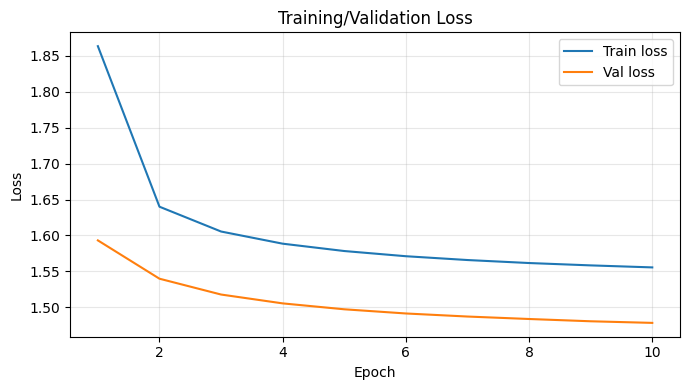

In [13]:
print("Starting training...")
train_losses: list[float] = []
val_losses: list[float] = []
for epoch in range(1, (CFG.training.epochs or 1) + 1):
    tr = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        max_grad_norm=CFG.training.max_grad_norm,
        progress_desc=f"epoch {epoch}/{CFG.training.epochs or 1}",
    )
    va = valid_epoch(model, val_loader, device)
    if scheduler is not None:
        scheduler.step()
    train_losses.append(tr)
    val_losses.append(va)
    print(f"epoch {epoch}: train={tr:.4f} val={va:.4f}")

if len(train_losses) > 0:
    epochs_axis = list(range(1, len(train_losses) + 1))
    plt.figure(figsize=(7, 4))
    plt.plot(epochs_axis, train_losses, label="Train loss")
    plt.plot(epochs_axis, val_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training/Validation Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

## Checkpointing

We save a minimal checkpoint containing the model parameters and the vocabulary. This
is sufficient to run inference and evaluation later without retraining.

In [14]:
save_checkpoint(model, vocab, state_path=str(Path("data") / "lstm_state.pt"), vocab_path=str(Path("data") / "vocab.pt"))
print("Saved model state and vocab to data/.")

Saved model state and vocab to data/.


## Evaluation: LSTM on Test Split

Using the assignment protocol, we evaluate ROUGE-1/2 (precision, recall, F1) by
generating the last quarter of each text from its first three quarters and comparing to
the reference continuation.

In [15]:
test_scores = evaluate_on_texts(
    model,
    test_texts,
    vocab=vocab,
    device=device,
    max_new_tokens=CFG.generation.max_new_tokens,
    max_samples=CFG.evaluation.test_samples,
)
print("LSTM test ROUGE:", {k: round(v, 4) for k, v in test_scores.items()})

eval:   0%|          | 0/159464 [00:00<?, ?it/s]

LSTM test ROUGE: {'rouge1_p': 0.3707, 'rouge1_r': 0.5536, 'rouge1_f1': 0.4197, 'rouge2_p': 0.1321, 'rouge2_r': 0.2086, 'rouge2_f1': 0.1505}


## Evaluation: DistilGPT2 Baseline

We benchmark a pretrained `distilgpt2` via the transformers text-generation pipeline on
the same protocol to contextualize the LSTM’s performance.

In [16]:
gpt2_test_scores = evaluate_gpt2_on_texts(
    texts=test_texts,
    vocab=vocab,
    device=device,
    model_name=CFG.gpt2.model_name,
    max_new_tokens=CFG.generation.max_new_tokens,
    max_samples=CFG.gpt2.eval_samples,
    token_pattern=CFG.tokenizer.token_pattern,
)
print("GPT2 Test ROUGE:", {k: round(v, 4) for k, v in gpt2_test_scores.items()})

gpt2-eval:   0%|          | 0/159464 [00:00<?, ?it/s]

GPT2 Test ROUGE: {'rouge1_p': 0.1716, 'rouge1_r': 0.3686, 'rouge1_f1': 0.2252, 'rouge2_p': 0.0455, 'rouge2_r': 0.0971, 'rouge2_f1': 0.0603}


## Results Summary and Qualitative Examples

We print ROUGE summaries for both models, provide a side-by-side comparison, and show
qualitative completions for a handful of train/validation/test samples to build
intuition beyond aggregate metrics.

In [17]:
print_scores("LSTM Test ROUGE (P/R/F1):", test_scores)
print_scores("DistilGPT2 Test ROUGE (P/R/F1):", gpt2_test_scores)
print_comparison("LSTM (Test)", test_scores, "DistilGPT2 (Test)", gpt2_test_scores)


LSTM Test ROUGE (P/R/F1):
{'rouge1_p': '0.371', 'rouge1_r': '0.554', 'rouge1_f1': '0.420', 'rouge2_p': '0.132', 'rouge2_r': '0.209', 'rouge2_f1': '0.150'}

DistilGPT2 Test ROUGE (P/R/F1):
{'rouge1_p': '0.172', 'rouge1_r': '0.369', 'rouge1_f1': '0.225', 'rouge2_p': '0.045', 'rouge2_r': '0.097', 'rouge2_f1': '0.060'}

Delta DistilGPT2 (Test) vs LSTM (Test) (positive means DistilGPT2 (Test) better):
{'rouge1_f1': '-0.195', 'rouge2_f1': '-0.090', 'rouge1_p': '-0.199', 'rouge1_r': '-0.185', 'rouge2_p': '-0.087', 'rouge2_r': '-0.111'}


In [18]:
show_examples(model, train_texts, vocab, device, CFG.generation.max_new_tokens, k=3)
show_examples(model, val_texts, vocab, device, CFG.generation.max_new_tokens, k=3)


---
prefix: h o   f a r   o u l d   u   a n t   t o   g o   f o r   a   f r i e n d ?  
prefix_len: 39 ref_tail_len: 14
pred  : i   a n t   t o   g o   t o   t h e   b
ref   : u p   t o   u ,   y i n g
ROUGE1-F1: 0.4848

---
prefix: a h l e y y y !   h e y z   h o   a r e   y a ?   o m g   c h o o l   t o m o r r o   t h i
prefix_len: 47 ref_tail_len: 16
pred  :   m o r n i n g   i   a   g o o d   t o
ref   :   u c k .   b i g   t i m e .
ROUGE1-F1: 0.4571

---
prefix: a a y   t o   a t c h   d r a g   m e  
prefix_len: 21 ref_tail_len: 8
pred  : t o   b e   a   g o o d   t i m e   i t
ref   : t o   h e l l
ROUGE1-F1: 0.2963

---
prefix: n o t   a t c h i n g   t h e   r a c e , t h i   a   u p p o e d   t o   b e   t h e   m t l   r a c e
prefix_len: 53 ref_tail_len: 18
pred  :   t o   t h e   b e t   t i m e   i t h
ref   :   ,   i ' m   i n   a u r o r a .
ROUGE1-F1: 0.4324

---
prefix: t h e   e a o n   f i n a l e   o f   g o i p   g i r l   a   o   g o o d ! ! . .   c a n ' t   

In [19]:
show_examples(model, test_texts, vocab, device, CFG.generation.max_new_tokens, k=8)


---
prefix: p a i n t i n g   r e a l   t h i n g   i   n o t   t h e   t h i n g   i ' m   t h e   b e t   a t   h a v e   t o   r e - d o  
prefix_len: 66 ref_tail_len: 20
pred  : t h e   b e t   t o   t h e   b e t   t
ref   : m y   p a i n t i n g   e n t i r e l y
ROUGE1-F1: 0.3

---
prefix: b u t   n o   v i d e o   o r   v o i c e   a c t i v a t i o n   i   g u e   e ' l l   b e  
prefix_len: 48 ref_tail_len: 16
pred  : a   g o o d   t i m e   i t h   m y   b
ref   : g e t t i n g   t h e   3 g  
ROUGE1-F1: 0.5143

---
prefix: b a b y i t t i n g   m y   f a v o r i t e   b o y .   t h e n   c o m i n g   h o m
prefix_len: 44 ref_tail_len: 15
pred  : e   a n d   i   a m   o   b a d   i t h
ref   : e   a n d   r e a d i n g .
ROUGE1-F1: 0.5294

---
prefix: y u c k   o   o r r y   -   i   h a d   t o   f l a t   l a t   e e k   o   i   f e e l   y o u r   p a i n .   i   t h i n k   1
prefix_len: 66 ref_tail_len: 20
pred  : 0 0   f o l l o e r   a n d   i   a m  
ref   : 1 4   m

## Conclusion

We select the better model by ROUGE-1 F1 on the test split and print the decision. In
practice, the transformer baseline often wins on quality, while the LSTM may be
preferable under strict memory and latency constraints. The final choice depends on the
target device budget and user experience requirements.

In [20]:
gpt2_r1 = gpt2_test_scores.get("rouge1_f1")
lstm_r1 = test_scores.get("rouge1_f1")
gpt2_test = float(gpt2_r1) if isinstance(gpt2_r1, int | float) and gpt2_r1 == gpt2_r1 else float("nan")
lstm_test = float(lstm_r1) if isinstance(lstm_r1, int | float) and lstm_r1 == lstm_r1 else float("nan")
better = "DistilGPT2" if gpt2_test > lstm_test else "LSTM"
print(f"Conclusion: {better} performed better on ROUGE-1 F1 on the test split.")

Conclusion: LSTM performed better on ROUGE-1 F1 on the test split.
